# Evaluation Example

This notebook demonstrates how to evaluate trajectories using `fomo_sdk`.

In [1]:
from fomo_sdk.evaluation.utils import construct_matrix
from fomo_sdk.evaluation.trajectories import (
    process_trajectories,
    compute_ape,
    compute_rpe_set,
    create_rpe_table,
    compute_ate_rmse,
    evaluate,
)
from fomo_sdk.evaluation.visualization import (
    plot_evaluation_matrix,
    create_evaluation_figure,
)
from fomo_sdk.common.naming import (
    construct_path,
    construct_evaluation_file_name,
    construct_mapping_recording,
    construct_localization_recording,
    construct_path_from_filename,
)
from pathlib import Path
from matplotlib import pyplot as plt

## 0. Configure paths

In [6]:
# Name of your slam system
slam = "evaluation example"

# Base path to the FoMo dataset (contains the deployment folders e.g. 2025-08-20...)
dataset_base_path = Path("data")
# Base path to the FoMo ground truth data, typically equal to the dataset_base_path
gt_base_path = Path("/Volumes/FoMo/ijrr")
# Deployment name
deployment = "2025-08-20"
# Trajectory name
trajectory = "green"

# Construct the path to the FoMo recording
fomo_path = construct_path(gt_base_path, deployment, trajectory)

# In this example we use the same recording for mapping and localization
localization_recording = fomo_path.name
mapping_recording = fomo_path.name

# output trajectories are always in the format <recording_mapping>_<recording_localization>.txt
est_file = dataset_base_path / construct_evaluation_file_name(
    mapping_recording, localization_recording
)

# ground truth trajectories are always in the the <recording_localization> folder together with the sensor data
gt_file = fomo_path / "gt.txt"

## 1. Evaluate a single trajectory

We will load two .txt files (one for the ground truth and one for the estimated trajectory) and compute the evaluation metrics.

Using first 2046 points for alignment


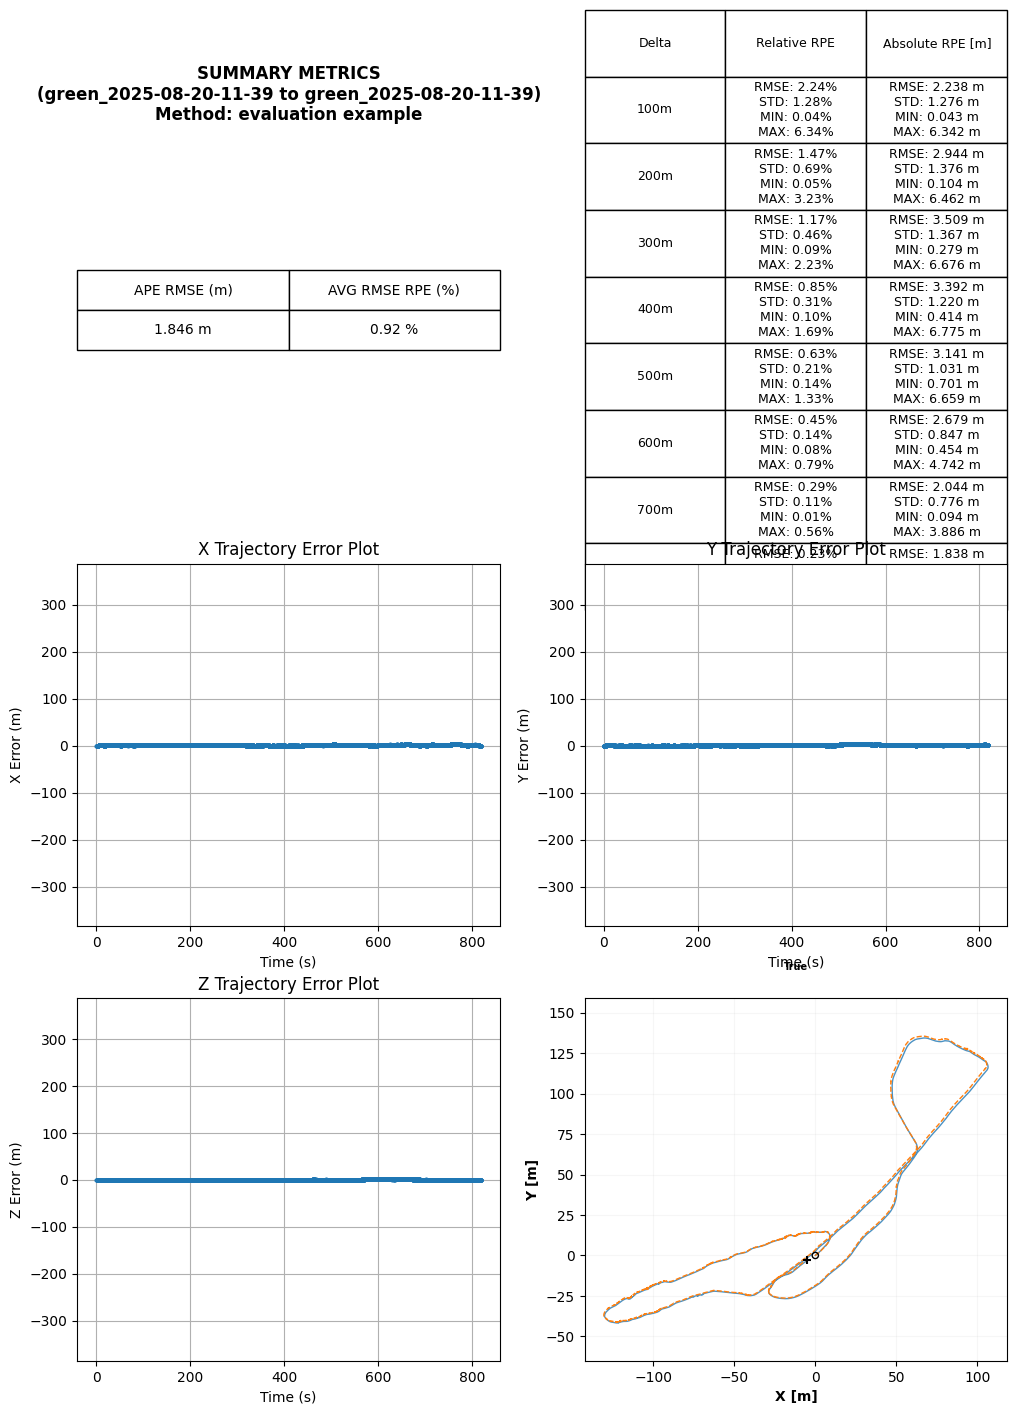

In [7]:
# Import and process the .txt tum files
traj_gt, traj_est, trajectories = process_trajectories(
    gt_file, est_file, alignment="kabsch"
)
traj_pair = (traj_gt, traj_est)

# Compute evaluation metrics
ape_rmse, ape_stats = compute_ape(traj_pair)

EVALUATION_DELTAS = [100, 200, 300, 400, 500, 600, 700, 800]

# We will see errors here since the red trajectory is too short to compute some of the deltas
rpe_results = compute_rpe_set(traj_pair, EVALUATION_DELTAS)

if len(rpe_results) == 0:
    raise ValueError(
        "\033[91mToo big deltas! Try turning on test mode with --test\033[0m"
    )

rpe_table, avg_relative_rpe = create_rpe_table(rpe_results)

_ate_rmse = compute_ate_rmse(rpe_results)
save_path = ""
create_evaluation_figure(
    traj_pair[0],
    traj_pair[1],
    rpe_table,
    avg_relative_rpe,
    ape_rmse,
    save_path,
    mapping_recording,
    localization_recording,
    slam,
    move_to_origin=True,
    plot_figure=True,
    export_figure=False,
)

## 2. Evaluate multiple trajectories and produce plot the evaluation matrix
Since our goal is to evaluate multiple trajectories across seasons, we can run the evaluation function in a loop.
The final output is the evaluation matrix.

Processing data/green_2025-08-20-11-39_green_2025-08-20-11-39.txt...
Using first 2046 points for alignment
Processing data/red_2025-10-14-11-41_red_2025-10-14-11-41.txt...
Using first 423 points for alignment
Error processing RPE for delta 400: delta = 400 (m) produced an empty index list - try lower values or a less strict tolerance
Skipping delta 400 due to processing error.
Error processing RPE for delta 500: delta = 500 (m) produced an empty index list - try lower values or a less strict tolerance
Skipping delta 500 due to processing error.
Error processing RPE for delta 600: delta = 600 (m) produced an empty index list - try lower values or a less strict tolerance
Skipping delta 600 due to processing error.
Error processing RPE for delta 700: delta = 700 (m) produced an empty index list - try lower values or a less strict tolerance
Skipping delta 700 due to processing error.
Error processing RPE for delta 800: delta = 800 (m) produced an empty index list - try lower values or a le

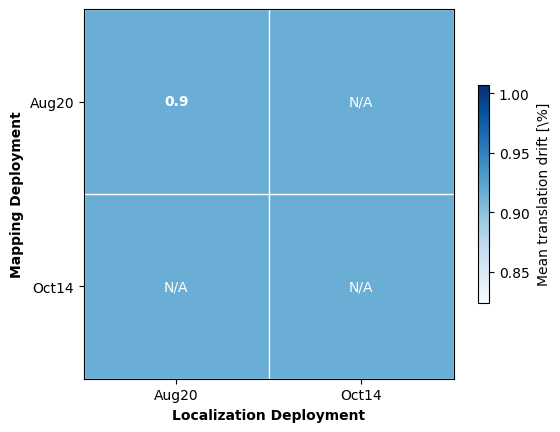

In [4]:
input_path = dataset_base_path
output_path = dataset_base_path

for path in sorted(input_path.glob("*.txt")):
    if path.suffix == ".txt":
        est_file = path
        mapping_date = construct_mapping_recording(path.name)
        localization_date = construct_localization_recording(path.name)
        yaml_filename = output_path / construct_evaluation_file_name(
            mapping_date, localization_date, ".yaml"
        )
        try:
            gt_file = gt_base_path / construct_path_from_filename(est_file) / "gt.txt"
            print(f"Processing {est_file}...")
            evaluate(
                output_path,
                gt_file,
                est_file,
                "kabsch",
                mapping_date,
                localization_date,
                slam,
                move_to_origin=True,
                export_yaml=True,
                export_figure=True,
            )
        except Exception as e:
            with open(yaml_filename, "w") as _:
                pass
            print(f"An error occurred: {e}")

ape_matrix, rpe_matrix, add_marker_matrix, labels_maps, labels_locs = construct_matrix(
    output_path
)

fig, ax = plt.subplots(1, 1)
# Plot RTE confusion matrix
plot_evaluation_matrix(
    rpe_matrix,
    add_marker_matrix,
    labels_maps,
    labels_locs,
    slam,
    ax,
    cmap="Blues",
)
plt.show()